In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

data = fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in stratSplit.split(dfData[data["feature_names"]], dfData["target"]):
    X_train = dfData[data["feature_names"]].iloc[train_index]
    X_test = dfData[data["feature_names"]].iloc[test_index]
    
    y_train = dfData["target"].iloc[train_index]
    y_test = dfData["target"].iloc[test_index]

In [2]:
from sklearn.decomposition import NMF

nnmf = NMF(n_components=100,
           init=None, # matrix initialization method, can heavily impact fitting time
           solver='cd', # optimization procedure
           shuffle=True, # shuffle cd coordinate orders
           beta_loss='frobenius', # loss function to use
                           # https://scikit-learn.org/stable/modules/decomposition.html#nmf-with-a-beta-divergence
           tol=1e-4,
           max_iter=200,
           alpha=0, # regularization parameter
           l1_ratio=0,
           random_state=0, # if initialization contains random component as well as for cd
           verbose=False
         )
X_train_transf = nnmf.fit_transform(X_train) # W matrix
X_test_transf = nnmf.transform(X_test)# W' matrix

In [3]:
print(nnmf.components_.shape) # H matix
print(nnmf.reconstruction_err_) # metric based on beta_loss metricc
print(nnmf.n_iter_)

(100, 784)
156322.42358805396
199


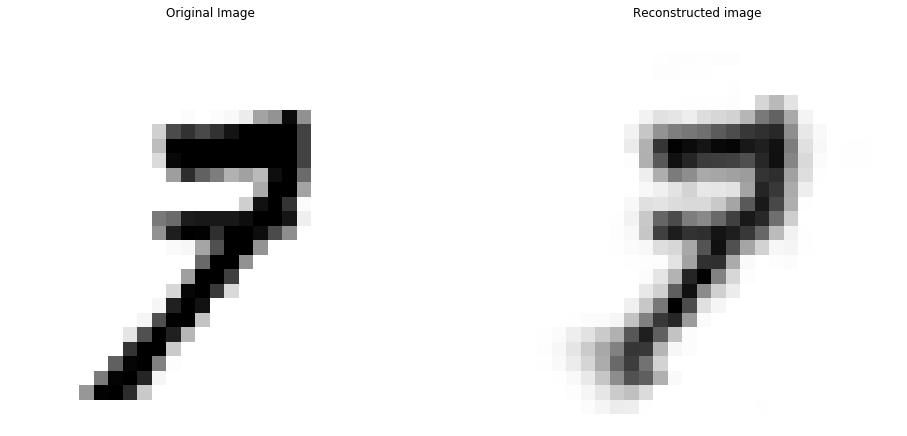

In [4]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121)
plt.imshow(X_train.astype(float).values[0].reshape(28,28),cmap=plt.get_cmap('gray_r'))
plt.title('Original Image')
plt.axis('off')
ax = fig.add_subplot(122)
X_rec = nnmf.inverse_transform(X_train_transf)
plt.imshow(X_rec[0].reshape(28,-1),cmap=plt.get_cmap('gray_r'))
plt.title('Reconstructed image')
plt.axis('off')
plt.show()

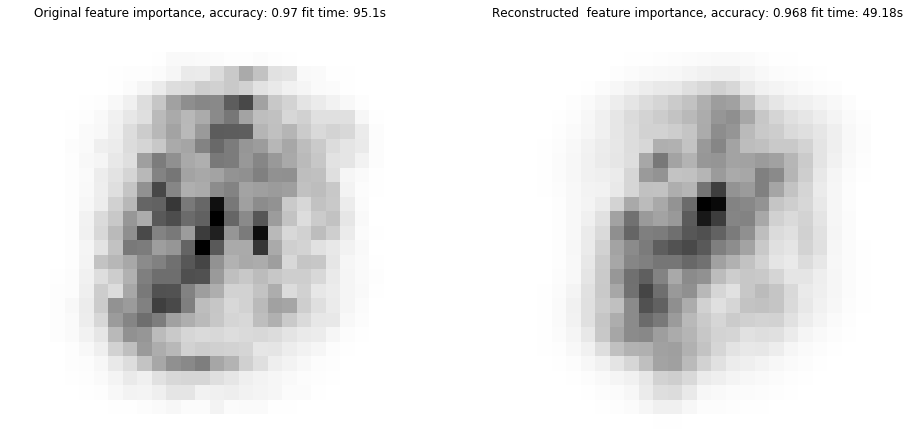

In [5]:
from sklearn.ensemble import RandomForestClassifier
import time

def transformData(X_train, X_test, method):
    X_train_transf = method.fit_transform(X_train)
    X_test_transf = method.transform(X_test)
    return X_train_transf, X_test_transf, method

def fitAndVisualize(X_train, y_train, X_test, y_test, X_train_transf, X_test_transf, method):
    rf_clf = RandomForestClassifier(random_state=0)
    rc_clf_red = RandomForestClassifier(random_state=0)

    start = time.time()
    rf_clf.fit(X_train, y_train)
    rcFit = time.time()-start

    start = time.time()
    rc_clf_red.fit(X_train_transf, y_train)
    rcRedFit = time.time()-start

    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(121)
    plt.imshow(rf_clf.feature_importances_.reshape(28,28),cmap=plt.get_cmap('gray_r'))
    plt.title('Original feature importance, accuracy: ' + 
              str(round(rf_clf.score(X_test,y_test),3)) + 
              ' fit time: '+str(round(rcFit,2)) + 's'
             )
    plt.axis('off')
    ax = fig.add_subplot(122)
    rc_clf_feat_rec = method.inverse_transform(rc_clf_red.feature_importances_)
    plt.imshow(rc_clf_feat_rec.reshape(28,-1),cmap=plt.get_cmap('gray_r'))
    plt.title('Reconstructed  feature importance, accuracy: ' + 
              str(round(rc_clf_red.score(X_test_transf,y_test),3)) + 
              ' fit time: '+str(round(rcRedFit,2)) + 's'
             )
    plt.axis('off')
    plt.show()
    
X_train_transf, X_test_transf, method = transformData(X_train, X_test, NMF(n_components=100))
fitAndVisualize(X_train, y_train, X_test, y_test, X_train_transf, X_test_transf, method)

In [6]:
from sklearn.datasets import load_boston
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

data = load_boston()
data.keys()

X, y = data["data"], data["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipe = Pipeline([('std_scl',StandardScaler())
                ])
X_train = pipe.fit_transform(X_train)
X_test = pipe.transform(X_test)

# note features are not all guaranteed non-negative
for i in range(X_train.shape[1]):
    if X_train[:, i].min()<0:
        X_train[:, i] += -1*X_train[:, i].min()
        
for i in range(X_test.shape[1]):
    if X_test[:, i].min()<0:
        X_test[:, i] += -1*X_test[:, i].min()
        
        
X_train = pd.DataFrame(X_train,columns=data["feature_names"])
X_test = pd.DataFrame(X_test,columns=data["feature_names"])
y_train = pd.DataFrame(y_train,columns=["target"])
y_test = pd.DataFrame(y_test,columns=["target"])

standard ridge score: 0.58
Dim. red. ridge score: 0.209


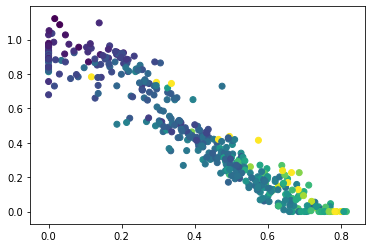

In [7]:
nnmf = NMF(n_components=2)
X_train_transf = nnmf.fit_transform(X_train)
X_test_transf = nnmf.transform(X_test)

ridge = Ridge()
ridge_red = Ridge()
ridge.fit(X_train, y_train)
ridge_red.fit(X_train_transf, y_train)
print('standard ridge score:', round(ridge.score(X_test, y_test),3))
print('Dim. red. ridge score:', round(ridge_red.score(X_test_transf, y_test),3))
plt.scatter(X_train_transf[:, 0], X_train_transf[:, 1],c=y_train['target'])
plt.show()